# Pipeline
### **NOTE 1**: 

We are using ready-to-use data that has already been through the pipeline.

Because of the time required to download, preprocess and train the models, the model here has already been trained and we are using the model predictions as saved in a zipfile in the `data` directory.

In order to run the pipeline end-to-end and reproduce the steps prior to this notebook, you will need to run the `run_demo.py` script in the `scripts/` directory.

#### The data:
Make sure you unzip the file `zip_data.zip`.

This will produce a folder `zip_data` which we will use as our base data directory. Remember, if you were to reproduce this analysis by running the pipeline from end-to-end then you would simply use the default data directory at `.data`.

Inside `data/zip_data` we have two directories. **`features`** and **`models`**.

**`features`** contains the data that has been through the `preprocessors` and the `engineers`. It only contains data for the `test` set in order to reduce the memory requirements. 

**`models`** contains data that has been predicted by the given model. It also contains a saved version.

Here we only have two models: **`ealstm`** and **`previous_month`** which is our baseline model.

### **NOTE 2**:
Here the data only includes the baseline `persistence` model and the state of the art Entity Aware Long-Short Term Memory (EALSTM) network. See the `notebooks/docs/Pipeline.ipynb` notebook for more information about the other models that we currently accomodate.

## Making Predictions

We have a pretrained model in the zipped data directory. Here we will make the predictions with the **EALSTM** model and the baseline **persistence** model.

In [122]:
from src.models import load_model, Persistence

In [123]:
# make predictions and save results to .nc with BASELINE model
persistence = Persistence(data_folder=data_dir)
persistence.evaluate()

RMSE: 16.653808601170777


In [126]:
ealstm_path = data_dir / 'models/one_month_forecast/ealstm/model_gcloud.pt'
assert ealstm_path.exists(), \
    'Expected the unzipped file to have the model.pt file saved'

ealstm = load_model(model_path=ealstm_path)

In [127]:
# have to specify the ignore_vars is empty 
ealstm.ignore_vars = []
ealstm.evaluate(
    save_results=True,
    save_preds=False,
)

RMSE: 40.941688537597656


/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


# evaluating the model

In [131]:
scores = annual_scores(
    data_path=data_dir,
    models=['ealstm', 'previous_month'],
    metrics=['rmse', 'r2'],
    verbose=False,
    to_dataframe=True
)

display(scores.head())

,month,ealstm,previous_month,metric
0,1.0,11.962646,15.918060,rmse
1,2.0,55.521111,9.609800,rmse
2,3.0,50.634243,18.995626,rmse
3,4.0,39.116074,24.495406,rmse
4,5.0,37.968170,18.025452,rmse


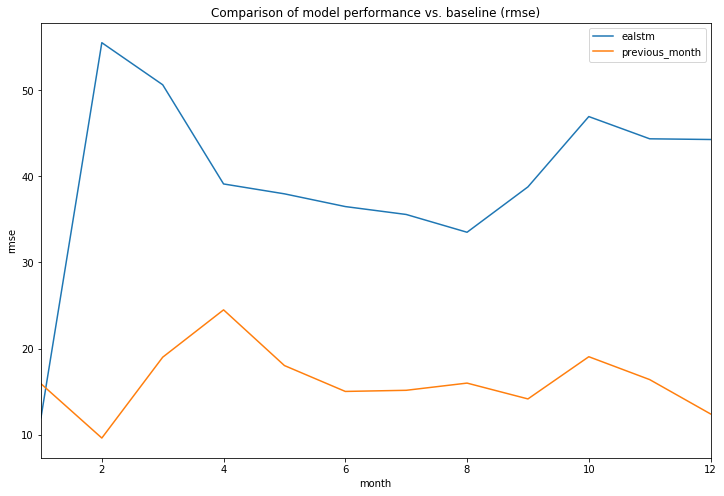

In [132]:
metric = 'rmse'
fig, ax = plt.subplots(figsize=(12, 8))
scores.loc[scores.metric == metric].plot(x='month', ax=ax)
ax.set_ylabel(metric)
ax.set_title(f'Comparison of model performance vs. baseline ({metric})');

In [52]:
# create long format dataframe
scores_long = pd.melt(
    scores, id_vars=['month', 'metric'], 
    value_vars=['ealstm', 'previous_month']
)
# get the separate metrics for plotting
rmse = scores_long.loc[scores_long.metric=='rmse']
r2 = scores_long.loc[scores_long.metric=='r2']

scores_long.head()

,month,metric,variable,value
0,1.0,rmse,ealstm,12.328923
1,2.0,rmse,ealstm,10.038730
2,3.0,rmse,ealstm,15.299802
3,4.0,rmse,ealstm,15.628013
4,5.0,rmse,ealstm,21.278271


Text(0.5, 1, 'RMSE Comparison for EALSTM vs. Baseline')

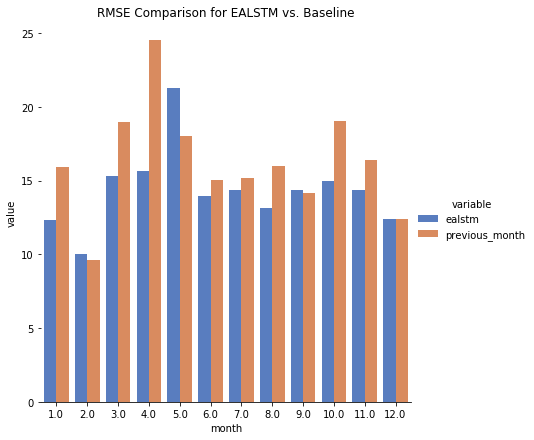

In [51]:
import seaborn as sns

g = sns.catplot(x="month", y="value", hue="variable", data=rmse,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
ax = plt.gca()
ax.set_title('RMSE Comparison for EALSTM vs. Baseline');

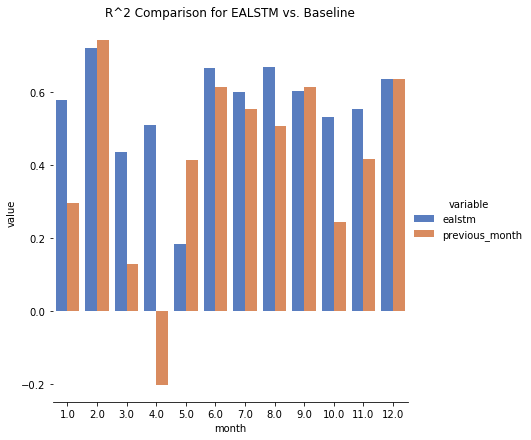

In [66]:
g = sns.catplot(x="month", y="value", hue="variable", data=r2,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
ax = plt.gca()
ax.set_title('R^2 Comparison for EALSTM vs. Baseline');

# geographyical analysis

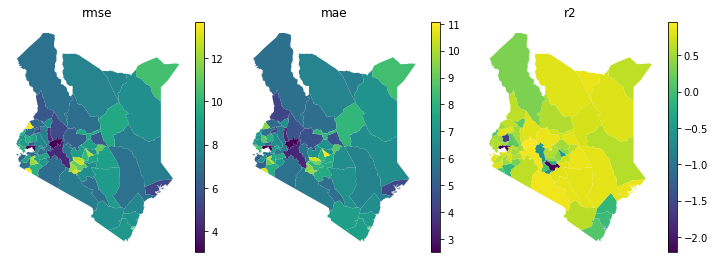

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize=(12, 8))

for ax, metric in zip(axs, ['rmse', 'mae', 'r2']):
    # nicely format the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    ax.set_title(metric)
    ax.axis('off')
    gdf.loc[(gdf.model == 'ealstm')].plot(metric, ax=ax, cax=cax, legend=True)

### How do we do when we compare to the [Adede et al 2019](https://www.mdpi.com/2072-4292/11/9/1099/htm) paper?


We will use one of the `indices` defined in `src/analysis/indices`. These all have a consistent api with one key method: `index.fit()`. Here we are just calculating a moving 3 month average.

In [35]:
from src.analysis import read_pred_data
from src.analysis import MovingAverage
from src.analysis.region_analysis import KenyaGroupbyRegion

In [43]:
ealstm_pred_ds, ealstm_pred_da = read_pred_data('ealstm', data_dir=data_dir)
persistence_pred_ds, persistence_pred_da = read_pred_data('previous_month', data_dir=data_dir)

true_paths = [f for f in (data_dir / 'features' / 'one_month_forecast' / 'test').glob('*/y.nc')]
true_ds = xr.open_mfdataset(true_paths).sortby('time').compute()
true_da = true_ds.VCI.transpose('time', 'lat', 'lon')

true_test_path = data_dir / 'features' / 'one_month_forecast' / 'test' / 'test_ALL.nc'
if not true_test_path.exists():
    true_da.to_netcdf(true_test_path)

# save the combined predictions 
ealstm_pred_path = (
    data_dir / 'models' / 'one_month_forecast' / 'ealstm' / 'preds_ALL.nc'
)
if not ealstm_pred_path.exists():
    ealstm_pred_da = ealstm_pred_da.sortby('time')
    ealstm_pred_da.to_netcdf(ealstm_pred_path)

persistence_pred_path = (
    data_dir / 'models' / 'one_month_forecast' / 'previous_month' / 'preds_ALL.nc'
)
if not ealstm_pred_path.exists():
    persistence_pred_da = persistence_pred_da.sortby('time')
    persistence_pred_da.to_netcdf(persistence_pred_path)

In [49]:
from typing import Dict
from sklearn.metrics import r2_score

def rolling_average(district_csv: pd.DataFrame) -> Dict[str, float]:
    relevant_districts = ['Mandera', 'Marsabit', 'Turkana', 'Wajir']

    district_csv['month'] = pd.to_datetime(district_csv.datetime).dt.month

    output_dict: Dict[str: float] = {}

    for district in relevant_districts:
        district_df = district_csv[district_csv.region_name == district.upper()]
        true, predicted = [], []
        for i in range(1, 12 - 1):
            min_month = i
            max_month = i + 3
            submonth = district_df[(district_df.month >= min_month) & (district_df.month < max_month)]
            predicted.append(submonth.predicted_mean_value.mean())
            true.append(submonth.true_mean_value.mean())
        district_score = r2_score(true, predicted)
        print(f'For {district}, r2 score: {district_score}')
        output_dict[district] = district_score

In [55]:
grouper = KenyaGroupbyRegion(data_dir)
grouper.analyze(
    da=ealstm_pred_da, selection='level_2', mean=True,
)
grouper.analyze(
    da=true_da, selection='level_2', mean=True,
)

l2_gdf = grouper.gdf

GroupbyRegion requires geopandas to be installed
* Running the Analyzer *
	 Admin Level: district_l2
	 Calculating statistics per region.
* Calculating DataFrame of values per Region *
* Joining DataFrame and GeoDataFrame *
* Joined to GeoDataFrame and saved to `self.gdf`*


In [2]:
l2_gdf.drop_duplicates([c for c in l2_gdf.columns if 'geometry' not in c]).head()

In [57]:
mean_vci3m = l2_gdf.groupby(['region_name']).mean().reset_index()

mean_gdf = grouper.join_dataframe_geodataframe(
    df=mean_vci3m, gdf=l2_gdf,
    gdf_colname='DISTNAME', df_colname='region_name'
)
mean_gdf.head()

,region_name,mean_value,DISTNAME,geometry
0,BARINGO,63.884841,BARINGO,"POLYGON ((36.04355473150635 1.250548937106019,..."
1,BARINGO,63.884841,BARINGO,"POLYGON ((36.04355473150635 1.250548937106019,..."
2,BARINGO,63.884841,BARINGO,"POLYGON ((36.04355473150635 1.250548937106019,..."
3,BARINGO,63.884841,BARINGO,"POLYGON ((36.04355473150635 1.250548937106019,..."
4,BARINGO,63.884841,BARINGO,"POLYGON ((36.04355473150635 1.250548937106019,..."


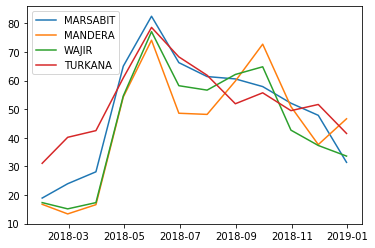

In [58]:
regions = ['TURKANA', 'MARSABIT', 'MANDERA', 'WAJIR']
assert np.isin(regions, l2_gdf.region_name.unique()).all()

rois = l2_gdf.loc[l2_gdf.region_name.isin(regions)]

# import seaborn as sns
import matplotlib.pyplot as plt

fig, ax =  plt.subplots()
for roi in rois.region_name.unique():
    subset = rois.loc[rois.region_name == roi]
    ax.plot(subset['datetime'], subset['mean_value'], label=roi)
plt.legend()


<xarray.Dataset>
Dimensions:                    (lat: 311, lon: 244, time: 10)
Coordinates:
  * time                       (time) datetime64[ns] 2018-02-28 ... 2018-11-30
  * lon                        (lon) float64 33.5 33.54 33.57 ... 42.21 42.25
  * lat                        (lat) float64 -5.17 -5.134 -5.098 ... 5.957 5.993
Data variables:
    VCI_3month_moving_average  (time, lat, lon) float32 19.508667 ... 33.0785

# Shap values

In [ ]:
input_pred_months

In [215]:
latitudes = latlons[:, 0]
longitudes = latlons[:, 1]
dims = ['lat', 'lon']
coords = {'lat': latitudes,
          'lon': longitudes}

xr.Dataset({'shap': (dims, values)}, coords=coords)


NameError: name 'variable_naems' is not defined